# Unmasking DeepFakes with simple Features

## importing required packages

* required to install numpy,opencv,matplotlib

In [1]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import pickle

## Pre-processing
## Discrete Fourier Transform & AzimuthalAverage
* this is done in imagepreprossing function 

In [2]:
power_specturm = {}#dictionary
epsilon = 1e-8

def imagepreprocessing(img): 
    #DFT of an image using FFT from numpy
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift += epsilon
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    
    #azimuthalAverage
    x, y = np.indices((magnitude_spectrum.shape))
    center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)
    np.seterr(divide = 'ignore') 
    tbin = np.bincount(r.ravel(), magnitude_spectrum.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    radialprofile=radialprofile[1:len(radialprofile)-1]
    return radialprofile 

## Loading Images and sending it to imagepreprocessing() function
### data set is avaliable in the folder
* fake images label is 0

In [40]:
#fake
cwd = os.getcwd()
datasetfake=cwd+"/FAKE"
listofimages=os.listdir(datasetfake)

for i in listofimages[:len(listofimages)]:
    imagename=datasetfake+"/"+i
    img1 = cv2.imread(imagename,0)
    w=len(img1[0])
    h=len(img1)
    power_specturm[i]={"data":imagepreprocessing(img1),"label":1}


* real images label is 1

In [33]:
#real
cwd1= os.getcwd()
datasetreal=cwd1+"/REAL"
listofimages1=os.listdir(datasetreal)

for i in listofimages1[:len(listofimages1)]:
    imagename=datasetreal+"/"+i
    img1 = cv2.imread(imagename,0)
    dim = (w, h)
    # resize image
    resized = cv2.resize(img1, dim, interpolation = cv2.INTER_AREA)
    
    power_specturm[i]={"data":imagepreprocessing(resized),"label":0}

* using the pickle library for storing the data

In [34]:
with open('datas.pkl','wb') as pickle_file:
    pickle.dump(power_specturm,pickle_file)
    pickle_file.close()
    

print("DONE")

DONE


## Extraction of Data

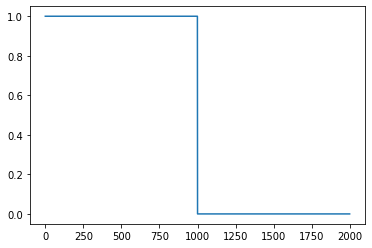

In [35]:
with open('datas.pkl','rb') as pickle_file1:
    power_specturm1=pickle.load(pickle_file1) 
    pickle_file1.close()


y=[]
X=[]

for i in power_specturm1:
        X.append(power_specturm1[i]["data"])
        y.append(power_specturm1[i]["label"])
        
#distribution
plt.plot(y)

## Classification

### logistic regression

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
num=10
LR=0
LR1=0
for z in range(num):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    logreg = LogisticRegression(solver='liblinear', max_iter=1000)
    logreg.fit(X_train, y_train)
    LR+=logreg.score(X_test, y_test)
    
print("Average LR for 2000 images: "+str(LR/num))

for z in range(num):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X[:1500], y[:1500], test_size = 0.2)
    logreg = LogisticRegression(solver='liblinear', max_iter=1000)
    logreg.fit(X_train, y_train)
    LR1+=logreg.score(X_test, y_test)
    
print("Average LR for 1500 images: "+str(LR1/num))



Average LR for 2000 images: 0.9627499999999998
Average LR for 1500 images: 0.9679999999999997


### SVM

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

from sklearn import svm
clf = svm.SVC(kernel='linear', C=1000)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test,y_pred)

print(acc)

0.9525


## GaussianNB

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

from sklearn.naive_bayes import GaussianNB
bayesclassifier = GaussianNB()

bayesclassifier.fit(X_train,y_train)
y_pred = bayesclassifier.predict(X_test)

from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test,y_pred)

print(acc)

0.8175


## Artificial neural network(ANN)

* Used Spyder Environment, TensorFlow and keras to run this code and 

* code in file ANN.py 